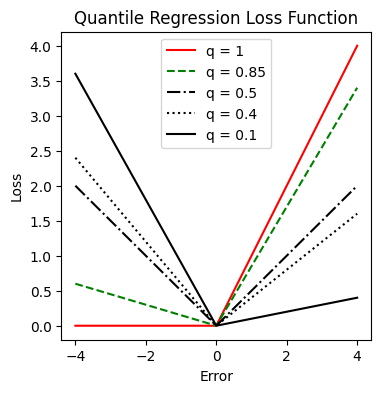

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_quantile_loss(quantiles):
    # Define the error range
    error_range = np.linspace(-4, 4, 1000)

    # Create a figure with a single plot and set the figure size
    fig, ax = plt.subplots(figsize=(4,4))
    
    for q, ls in zip(quantiles, ['solid', 'dashed', 'dashdot', 'dotted', "solid" , "solid"]):
        # Calculate the quantile loss for each error value
        loss = np.where(error_range > 0, q * error_range, (1 - q) * (-error_range))
        
        # Plot the quantile loss
        if q == 0.85:
            ax.plot(error_range, loss, label=f'q = {q}', color = "green", linewidth = 1.5, linestyle = ls)
        elif q == 1:
            ax.plot(error_range, loss, label=f'q = {q}', color = "red", linewidth = 1.5, linestyle = ls)
        else:
            ax.plot(error_range, loss, label=f'q = {q}', linestyle = ls, color = "black")
    
    ax.set_title('Quantile Regression Loss Function')
    ax.set_xlabel('Error')
    ax.set_ylabel('Loss')
    ax.legend()
    
    plt.savefig("/Users/bastian/Library/CloudStorage/Dropbox/DTU (Semester 10)/MscThesis/Final Plots for Thesis/quantile_loss_ill.pdf")

    # Display the plot
    plt.show()

# Example usage
quantiles = [1, 0.85, 0.5, 0.4, 0.1]
plot_quantile_loss(quantiles)

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Initialize session
# sess = tf.Session()

In [5]:
# Load data
mcycle = pd.read_csv('mcycle.txt',delimiter='\t')
mcycle.times = (mcycle.times - mcycle.times.mean())/mcycle.times.std()
mcycle.accel = (mcycle.accel - mcycle.accel.mean())/mcycle.accel.std()

# Reshape to input format for network
times = np.expand_dims(mcycle.times.values, 1)
accel = np.expand_dims(mcycle.accel.values, 1)

In [7]:
# Create network
class q_model:
    def __init__(self, 
                 sess, 
                 quantiles, 
                 in_shape=1, 
                 out_shape=1, 
                 batch_size=32):
        
        self.sess = sess
        
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.batch_size = batch_size
        
        self.outputs = []
        self.losses = []
        self.loss_history = []
        
        self.build_model()
        
    def build_model(self, scope='q_model', reuse=tf.compat.v1.AUTO_REUSE): 
        with tf.compat.v1.variable_scope(scope, reuse=reuse) as scope:
            self.x = tf.compat.v1.placeholder(tf.float32, shape=(None, self.in_shape))
            self.y = tf.compat.v1.placeholder(tf.float32, shape=(None, self.out_shape))

            self.layer0 = tf.keras.layers.Dense(units=32, activation=tf.nn.relu)(self.x)
            self.layer1 = tf.keras.layers.Dense(units=32, activation=tf.nn.relu)(self.layer0)

            # Create outputs and losses for all quantiles
            for i in range(self.num_quantiles):
                q = self.quantiles[i]
                
                # Get output layers 
                output = tf.keras.layers.Dense(1, name="{}_q{}".format(i, int(q*100)))(self.layer1)
                self.outputs.append(output)
                
                # Create losses
                
                error = self.y - output
                loss = tf.reduce_mean(tf.maximum(q*error, (q-1)*error), axis=-1)

                self.losses.append(loss)

            # Create combined loss
            self.combined_loss = tf.reduce_mean(tf.add_n(self.losses))
            self.train_step = tf.optimizers.Adam().minimize(self.combined_loss)

    def fit(self, x, y, epochs=100):  
        for epoch in range(epochs):
            epoch_losses = []
            for idx in range(0, x.shape[0], self.batch_size):
                batch_x = x[idx : min(idx + self.batch_size, x.shape[0]),:]
                batch_y = y[idx : min(idx + self.batch_size, y.shape[0]),:]

                feed_dict = {self.x: batch_x,
                             self.y: batch_y}

                _, c_loss = self.sess.run([self.train_step, self.combined_loss], feed_dict)
                epoch_losses.append(c_loss)
                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if epoch % 100 == 0:
                print("Epoch {}: {}".format(epoch, epoch_loss))
            
    def predict(self, x):   
        # Run model to get outputs
        feed_dict = {self.x: x}
        predictions = self.sess.run(self.outputs, feed_dict)
        
        return predictions


In [11]:
# Instantiate model
quantiles = [.1, .5, .9]
model = q_model(quantiles=quantiles, batch_size=32)

# Initialize all variables
model.build_model()
model.fit(times, accel, epochs=100)

# Initialize all variables
model.init_op = tf.compat.v1.global_variables_initializer()
tf.compat.v1.keras.backend.get_session().run(model.init_op)


TypeError: q_model.__init__() missing 1 required positional argument: 'sess'

In [44]:
# Run training
epochs = 2000
model.fit(times, accel, epochs)

Epoch 0: 1.28651762008667
Epoch 100: 0.566359281539917
Epoch 200: 0.4066397249698639
Epoch 300: 0.33803483843803406
Epoch 400: 0.30299827456474304
Epoch 500: 0.2755032181739807
Epoch 600: 0.25843241810798645
Epoch 700: 0.25172367691993713
Epoch 800: 0.24871711432933807
Epoch 900: 0.25110912322998047
Epoch 1000: 0.2475467175245285
Epoch 1100: 0.2458878606557846
Epoch 1200: 0.24449209868907928
Epoch 1300: 0.24454854428768158
Epoch 1400: 0.24357259273529053
Epoch 1500: 0.2434576004743576
Epoch 1600: 0.24177248775959015
Epoch 1700: 0.24332064390182495
Epoch 1800: 0.2407195121049881
Epoch 1900: 0.23958206176757812


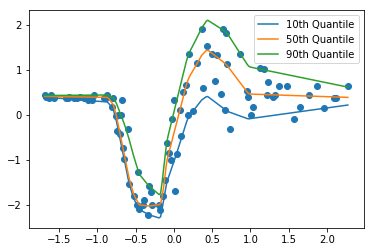

In [45]:
# Generate the range of data we'd like to predict
test_times = np.expand_dims(np.linspace(times.min(),times.max(),200), 1)
predictions = model.predict(test_times)

plt.scatter(times, accel)
for i, prediction in enumerate(predictions):
    plt.plot(test_times, prediction, label='{}th Quantile'.format(int(model.quantiles[i]*100)))
    
plt.legend()
plt.show()

In [27]:
model.outputs

[<tf.Tensor 'q_model_5/0_q10/BiasAdd:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'q_model_5/1_q50/BiasAdd:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'q_model_5/2_q90/BiasAdd:0' shape=(?, 1) dtype=float32>]